In [1]:
def plot_history(history, desc = ''):
    
    fig = plt.figure(figsize = (18 , 6))
    
    if desc:
        plt.title('{}'.format(desc), fontsize = 16, y = -0.1)

    subplot = (1, 2, 1)
    fig.add_subplot(*subplot)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['train loss', 'valid loss'])
    plt.grid(True)
    plt.plot()
    
    subplot = (1, 2, 2)
    fig.add_subplot(*subplot)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend(['train acc', 'valid acc'])
    plt.grid(True)
    plt.plot()

def crop_brain_contour(image, plot=False):
    
    # Convert the image to grayscale, and blur it slightly
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # Find contours in thresholded image, then grab the largest one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)
    
    # extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    
    # crop new image out of the original image using the four extreme points (left, right, top, bottom)
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]  
    
    return new_image

In [2]:
import os 
import re
import cv2
import numpy as np
import seaborn as sns
!pip install imutils
import imutils
import tensorflow as tf
from tensorflow.keras import models
from tensorflow.keras import layers
from IPython.display import Image
import matplotlib.cm as cm
from tqdm import tqdm
import matplotlib.pyplot as plt
barsize = '{l_bar}{bar:10}{r_bar}{bar:-10b}'


[notice] A new release of pip is available: 24.1.1 -> 24.3.1
[notice] To update, run: C:\Users\Gaeming PeeCee\anaconda3\python.exe -m pip install --upgrade pip


In [3]:
IMGS = 256

In [4]:
IMGS = 256  # Image size
main = r'C:\Users\Gaeming PeeCee\Downloads\kaggle\chest_xray'
categ = ['test', 'train', 'val']
classes = ['PNEUMONIA', 'NORMAL']

images = []
labels = []

# Load images and preprocess
for i in categ:
    sub_path = os.path.join(main, i)
    for j in classes:
        path = os.path.join(sub_path, j)
        temp = os.listdir(path)
        for x in temp:
            addr = os.path.join(path, x)
            img_arr = cv2.imread(addr)
            img_arr = cv2.resize(img_arr, (IMGS, IMGS))
            
            # Ensure 3 channels
            if len(img_arr.shape) == 2:  # Grayscale
                img_arr = cv2.cvtColor(img_arr, cv2.COLOR_GRAY2RGB)
            
            images.append(img_arr)
            labels.append(1 if j == 'PNEUMONIA' else 0)

images = np.array(images) / 255.0  # Normalize to [0, 1]
labels = np.array(labels)

print(f"Images shape: {images.shape}, Labels shape: {labels.shape}")

Images shape: (5856, 256, 256, 3), Labels shape: (5856,)


In [5]:
from sklearn.model_selection import train_test_split as tts
x_train, x_test, y_train, y_test = tts(images, labels, random_state = 42, test_size = .30)
x_valid, x_test, y_valid, y_test = tts(x_test, y_test, random_state = 42, test_size = .50)

In [6]:
x_train = x_train.reshape(-1, IMGS, IMGS, 3)
x_valid = x_valid.reshape(-1, IMGS, IMGS, 3)
x_test = x_test.reshape(-1, IMGS, IMGS, 3)

In [7]:
# import numpy as np
# from sklearn.utils.class_weight import compute_class_weight
# class_weight = compute_class_weight(class_weight="balanced", classes=np.unique(y_train), y=y_train)
# class_weight_dict = {}
# for i in range(len(class_weight)):
#     class_weight_dict[i]=class_weight[i]
# print(class_weight_dict)

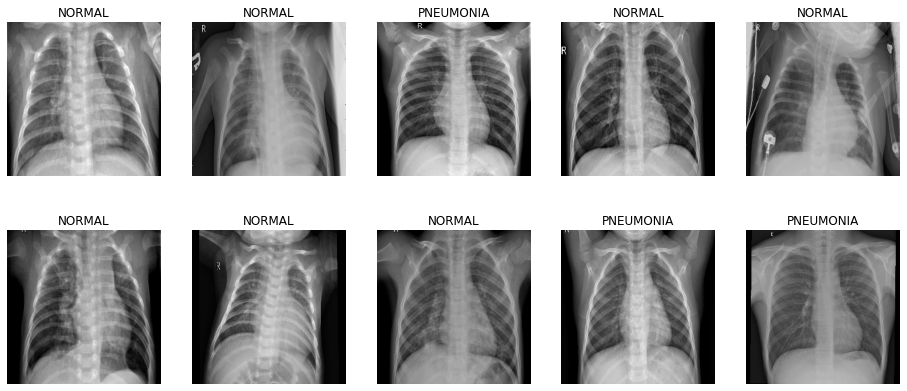

In [8]:
fig = plt.figure(figsize = (16,7))
z = np.random.randint(1, 5000, 11)
rows = 2
columns = 5
for i in range(1, rows*columns+1):
    fig.add_subplot(rows, columns, i)
    plt.imshow(images[z[i]])
    plt.title(classes[labels[z[i]]])
    plt.axis(False)
plt.show()

In [9]:
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)
print(x_valid.shape, y_valid.shape)

(4099, 256, 256, 3) (4099,)
(879, 256, 256, 3) (879,)
(878, 256, 256, 3) (878,)


In [10]:
class my_callbacks(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs = {}):
        if (logs.get('val_accuracy') > .99):
            print("Accuracy is High Enough so Stopping Training")
            self.model.stop_training= True

In [11]:
base_model = tf.keras.applications.VGG16(weights = 'imagenet',
                                            include_top = False,
                                            input_shape = (IMGS, IMGS, 3))

last = base_model.get_layer('block3_pool').output
x = layers.GlobalAveragePooling2D()(last)
x = layers.Dense(256, activation = 'relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(128, activation = 'relu')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(32, activation = 'relu')(x)
pred = layers.Dense(1, activation = 'sigmoid')(x)

In [12]:
import tensorflow as tf
from tensorflow.keras import Model

# Define model using tf.keras.Model
model = Model(inputs=base_model.input, outputs=pred)

# Compile the model
model.compile(loss='binary_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics=['accuracy'])

In [13]:
callback = my_callbacks()
history = model.fit(x_train, y_train, epochs = 20, batch_size = 32, validation_data = (x_valid, y_valid), callbacks = [callback])

Epoch 1/20
129/129 [==============================] - 71s 399ms/step - loss: 0.4505 - accuracy: 0.7917 - val_loss: 0.2771 - val_accuracy: 0.8884
Epoch 2/20
129/129 [==============================] - 46s 360ms/step - loss: 0.3189 - accuracy: 0.8558 - val_loss: 0.2367 - val_accuracy: 0.9066
Epoch 3/20
129/129 [==============================] - 46s 358ms/step - loss: 0.2992 - accuracy: 0.8648 - val_loss: 0.2111 - val_accuracy: 0.9134
Epoch 4/20
129/129 [==============================] - 47s 364ms/step - loss: 0.2463 - accuracy: 0.8922 - val_loss: 0.2365 - val_accuracy: 0.9066
Epoch 5/20
129/129 [==============================] - 46s 360ms/step - loss: 0.2114 - accuracy: 0.9151 - val_loss: 0.1409 - val_accuracy: 0.9499
Epoch 6/20
129/129 [==============================] - 48s 369ms/step - loss: 0.1886 - accuracy: 0.9290 - val_loss: 0.1622 - val_accuracy: 0.9419
Epoch 7/20
129/129 [==============================] - 47s 364ms/step - loss: 0.2105 - accuracy: 0.9168 - val_loss: 0.1324 - val_ac

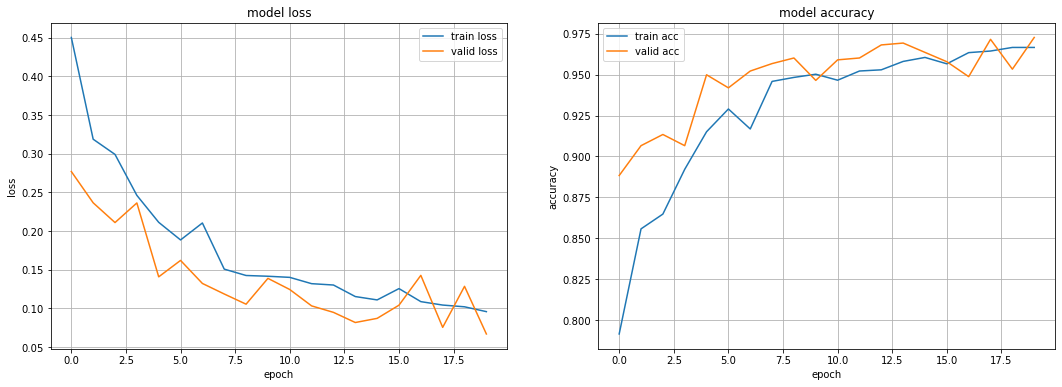

In [14]:
plot_history(history)

In [15]:
model.evaluate(x_test, y_test)

28/28 [==============================] - 3s 112ms/step - loss: 0.1121 - accuracy: 0.9579


[0.1121496632695198, 0.9579067230224609]

In [16]:
y_pred = model.predict(x_test)

28/28 [==============================] - 3s 88ms/step


In [17]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(np.round(y_pred),y_test))

              precision    recall  f1-score   support

         0.0       0.89      0.95      0.92       214
         1.0       0.98      0.96      0.97       665

    accuracy                           0.96       879
   macro avg       0.93      0.95      0.94       879
weighted avg       0.96      0.96      0.96       879



In [18]:
y_pred = np.round(y_pred)
y_pred = y_pred.reshape(-1,)
y_test = y_test.astype('float')
y_test.shape

(879,)

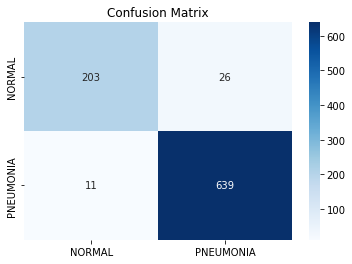

In [19]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming y_test and y_pred are available
# Replace with your actual class names
class_names = ['NORMAL', 'PNEUMONIA']

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the heatmap
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names)

# Add labels
plt.title('Confusion Matrix')
plt.show()

In [20]:
from keras.models import load_model
model.save('p_model.h5')
new_model = load_model('p_model.h5')

In [21]:
new_model = load_model('p_model.h5')

In [22]:
new_model.evaluate(x_test, y_test)

28/28 [==============================] - 3s 90ms/step - loss: 0.1121 - accuracy: 0.9579


[0.1121496632695198, 0.9579067230224609]

In [23]:
new_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

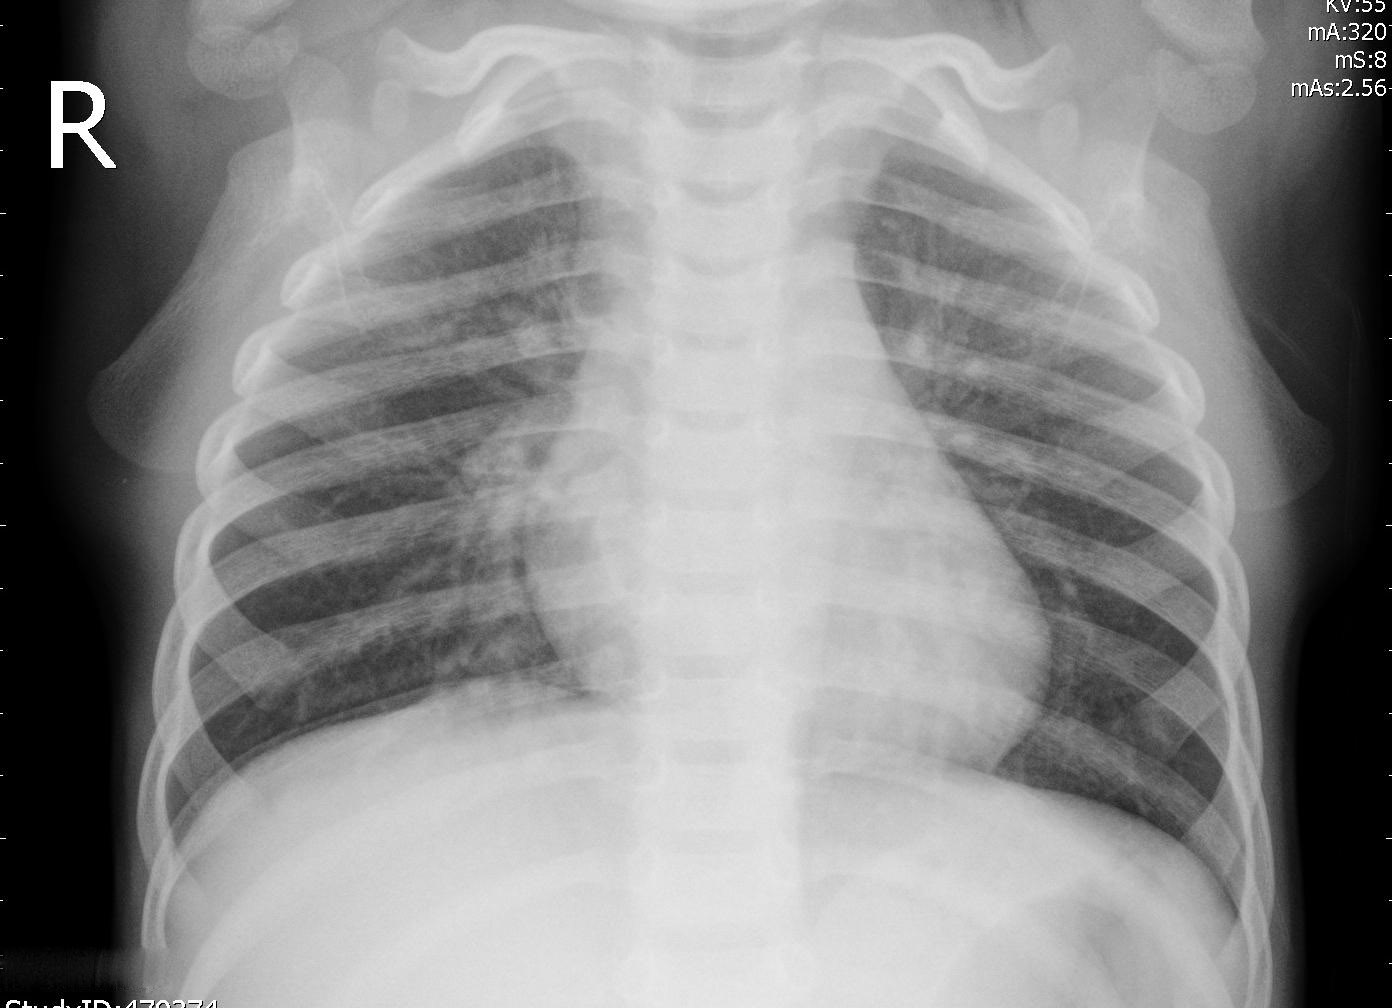

In [24]:
from IPython.display import Image, display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import keras

model_builder = keras.applications.xception.Xception
img_size = (299, 299)
preprocess_input = keras.applications.xception.preprocess_input
decode_predictions = keras.applications.xception.decode_predictions

last_conv_layer_name = "block3_pool"

## The local path to our target image

img_path= r"C:\Users\Gaeming PeeCee\Downloads\kaggle\chest_xray\test\PNEUMONIA\person44_virus_94.jpeg"

display(Image(img_path))
def get_img_array(img_path, size):
    ## `img` is a PIL image 
    img = keras.utils.load_img(img_path, target_size=size)
    array = keras.utils.img_to_array(img)
    ## We add a dimension to transform our array into a "batch"
    array = np.expand_dims(array, axis=0)
    return array


def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    ## First, we create a model that maps the input image to the activations
    ## of the last conv layer as well as the output predictions
    grad_model = keras.models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).output, model.output]
    )

    ## Then, we compute the gradient of the top predicted class for our input image
    ## for the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    ## We are doing transfer learning on last layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    ## This is a vector where each entry is the mean intensity of the gradient
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    ## calculates a heatmap highlighting the regions of importance in an image
    ## for a specific 
    ## predicted class by combining the output of the last convolutional layer
    ## with the pooled gradients.
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    ## For visualization purpose
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

1/1 [==============================] - 1s 609ms/step
Predicted of image: [('n01990800', 'isopod', 5.087006)]


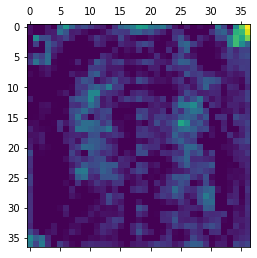

In [25]:
## Preparing the image
img_array = preprocess_input(get_img_array(img_path, size=img_size))

## Making the model with imagenet dataset
model = model_builder(weights="imagenet")

## Remove last layer's softmax(transfer learning)
model.layers[-1].activation = None

preds = model.predict(img_array)

## Generate class activation heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

## visulization of heatmap
plt.matshow(heatmap)
plt.show()

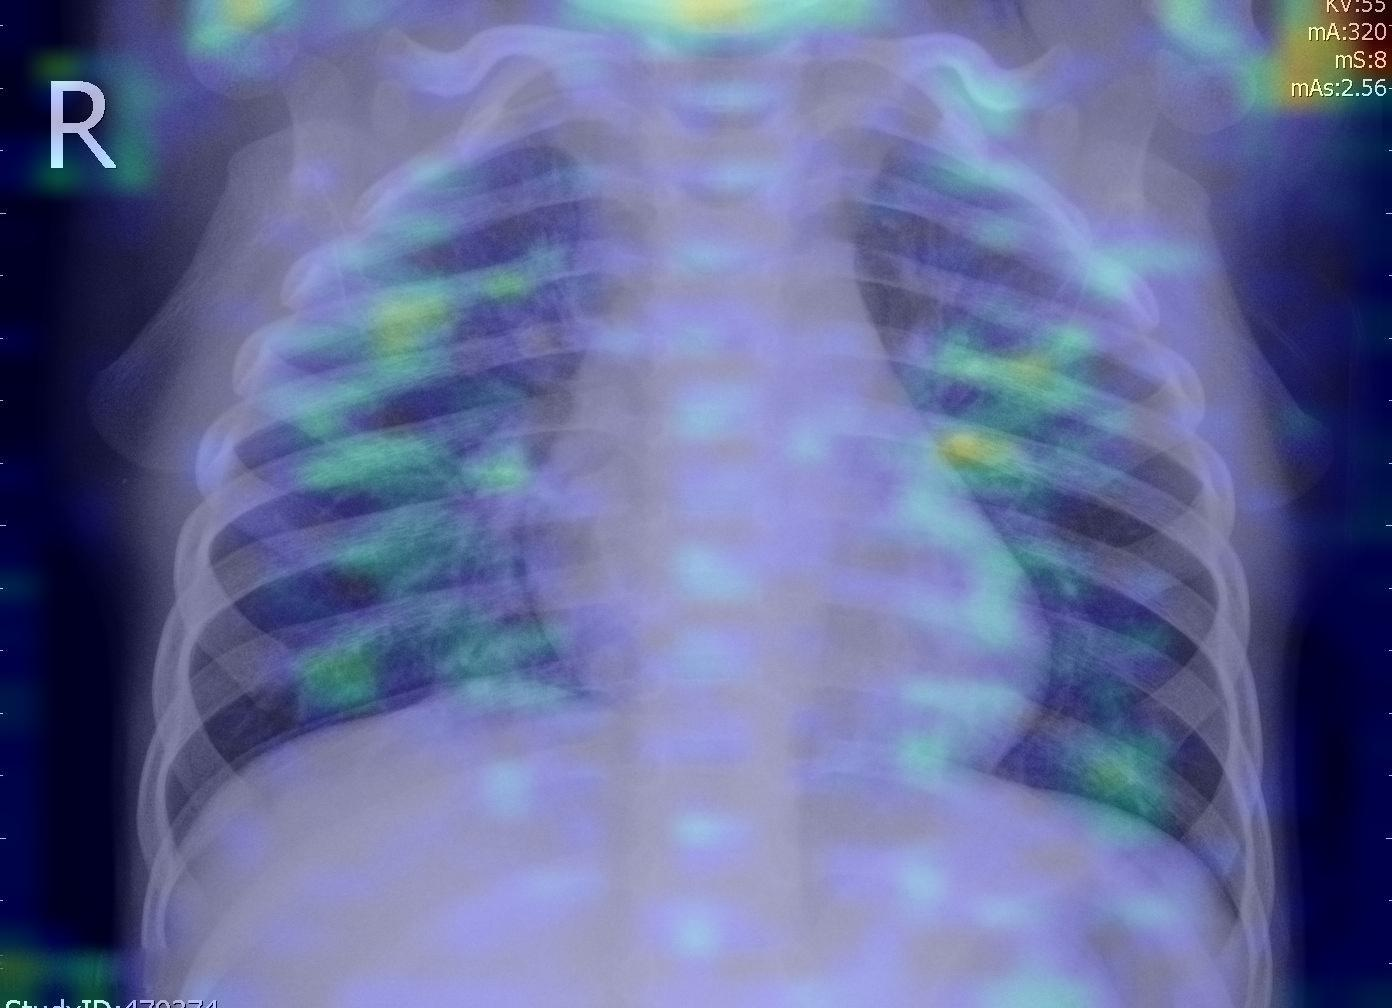

In [26]:
def save_and_display_gradcam(img_path, heatmap, cam_path="save_cam_image.jpg", alpha=0.4):
    ## Loading the original image
    img = keras.utils.load_img(img_path)
    img = keras.utils.img_to_array(img)

    ## Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    ## Use jet colormap to colorize heatmap
    jet = mpl.colormaps["jet"]

    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    ## Create an image with RGB colorized heatmap
    jet_heatmap = keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.utils.img_to_array(jet_heatmap)

    ## Superimpose the heatmap on original image
    Superimposed_img = jet_heatmap * alpha + img
    Superimposed_img = keras.utils.array_to_img(Superimposed_img)

    ## Save the superimposed image
    Superimposed_img.save(cam_path)

    ## Displaying Grad CAM
    display(Image(cam_path))


save_and_display_gradcam(img_path, heatmap)

1/1 [==============================] - 0s 352ms/step
[1.]
[1]


Text(0.5, 1.0, 'Input Image')

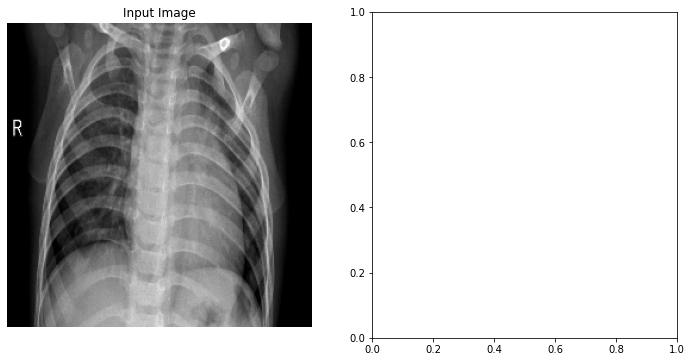

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf

# Replace with your actual class names and image path
class_names = ['NORMAL', 'PNEUMONIA']  # Update with your model's class labels
image_path = r"C:\Users\Gaeming PeeCee\Downloads\kaggle\chest_xray\test\NORMAL\NORMAL2-IM-0338-0001.jpeg"

# Load and preprocess the image
def preprocess_image(image_path, target_size=(256, 256)):
#     img = Image.open(image_path).convert('RGB')
#     img = img.resize(target_size)
#     img_array = np.array(img) / 255.0  # Normalize pixel values
#     return np.expand_dims(img_array, axis=0), img
    img_arr = cv2.imread(image_path)
    img_arr = cv2.resize(img_arr, (IMGS, IMGS))
    return np.expand_dims(np.array(img_arr), axis= 0),np.array(img_arr)

# Preprocess the image
input_data, img = preprocess_image(image_path)

# Make predictions
predictions = new_model.predict(input_data)[0]
print(predictions)
predicted_class = np.where(predictions>0.5,1,0)
print(predicted_class)
predicted_probability= predictions if predictions > 0.5 else 1 - predictions

# Display the image and bar chart
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Show the image
axes[0].imshow(img)
axes[0].axis('off')  # Hide axes
axes[0].set_title('Input Image')

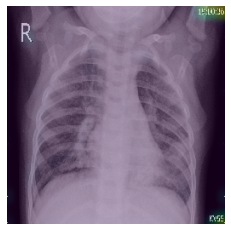

In [9]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Load the model
model = tf.keras.models.load_model("p_model.h5")

# Load and preprocess an image
def preprocess_image(image_path, target_size):
    img = load_img(image_path, target_size=target_size)
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = img_array / 255.0  # Normalize to [0, 1] range
    return img, img_array

# Grad-CAM function
def make_gradcam_heatmap(model, img_array, layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs], 
        [model.get_layer(layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    # Compute gradients
    grads = tape.gradient(class_channel, conv_outputs)

    # Compute the mean intensity of the gradients
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Multiply the pooled gradients with the convolution outputs
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # Normalize the heatmap
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# Overlay heatmap on image
def overlay_heatmap(heatmap, img, alpha=0.3, colormap='viridis'):
    heatmap = np.uint8(255 * heatmap)
    colormap = plt.cm.get_cmap(colormap)
    colormap_colors = colormap(np.arange(256))[:, :3]
    colormap_heatmap = colormap_colors[heatmap]
    colormap_heatmap = tf.keras.preprocessing.image.array_to_img(colormap_heatmap)

    colormap_heatmap = colormap_heatmap.resize(img.size)
    superimposed_img = tf.keras.preprocessing.image.array_to_img(
        np.array(img) * (1 - alpha) + np.array(colormap_heatmap) * alpha
    )
    return superimposed_img

# Example usage
image_path = r"C:\Users\Gaeming PeeCee\Downloads\kaggle\chest_xray\test\PNEUMONIA\person49_virus_101.jpeg"  # Replace with your image path
img, img_array = preprocess_image(image_path, target_size=(256, 256))  # Adjust size as needed

# Replace 'last_conv_layer_name' with the name of your model's last convolutional layer
last_conv_layer_name = "block3_pool"  # Example layer name, check your model's architecture

heatmap = make_gradcam_heatmap(model, img_array, last_conv_layer_name)

# Display heatmap overlay
superimposed_img = overlay_heatmap(heatmap, img)
plt.imshow(superimposed_img)
plt.axis('off')
plt.show()
